In [1]:
import serial
from time import sleep
import numpy as np
import cv2
from IPython.display import clear_output
%matplotlib inline
from matplotlib import pyplot as plt

from utils import ones_state, vis, state_ones

In [2]:
BOARD_X, BOARD_Y = 400, 650
REST_X, REST_Y = 400, 500
BOARD_SIZE = 64
SPACE_SIZE = 100

In [3]:
class TwoAxis():
    def __init__(self):
        loc = "/dev/cu.usbmodem1411"
        self.ser = serial.Serial(loc, 115200)
        if self.ser is None:
            print("error, no serial")
            print("Don't forget to change the serial location for your system. Currently set to: {}".format(loc))
        
        print('waiting for response')
        #self.wait() # wait until ready
        sleep(2)
        self.ser.flush()
        print('connected')

    def wait(self):
        while True:
            if self.ser.readline():
                return
            
    def pen_down(self):
        self.ser.write(("00000,").encode('utf-8'))
    
    def pen_up(self):
        self.ser.write(("10000,").encode('utf-8'))

    def move(self, x_speed, y_speed):
        x_speed = int(np.floor((x_speed + 1.0)/2.0 * 99.0))
        y_speed = int(np.floor((y_speed + 1.0)/2.0 * 99.0))
        
        x_speed = "%02d"%x_speed
        y_speed = "%02d"%y_speed
        message = "2"+x_speed[0]+x_speed[1]+y_speed[0]+y_speed[1]+","
        #print(message)
        self.ser.write((message).encode('utf-8'))

# serial
ta = TwoAxis()

SerialException: [Errno 2] could not open port /dev/cu.usbmodem1411: [Errno 2] No such file or directory: '/dev/cu.usbmodem1411'

In [4]:
# camera

cam = cv2.VideoCapture(0)

(402, 498)


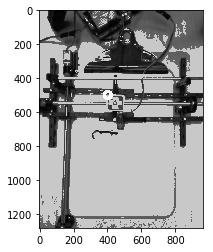

In [5]:
# pattern tracking for pen location

template = cv2.imread('pattern.png', 0)

def capture_img(cam, template=template):
    
    ret_val, img = cam.read()

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = np.transpose(img)
    img = np.flipud(img)
    img[img>100] = 200
    
    w, h = template.shape[::-1]

    res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    img = cv2.circle(img.copy(), max_loc, 20, 255, 20)
    
    return img, max_loc

img, max_loc = capture_img(cam)
print(max_loc)
plt.imshow(img, cmap=plt.cm.gray)
#plt.imshow(template)

In [6]:
# controlled movement

from math import atan2

def move_targeted(x, y):
    target = (x, y)
    close = False
    while not close:
        img, loc = capture_img(cam)
        #clear_output(wait=True)
        #plt.imshow(img, cmap=plt.cm.gray)
        #plt.show()
        
        dist = np.sqrt(np.square(x-loc[0]) + np.square(y-loc[1]))
        
        if dist < 2:
            close = True
            ta.move(0.0, 0.0)
            return
        
        angle = atan2(y-loc[1], x-loc[0])
        
        speed = 1
        if dist < 20:
            speed = .2

        diffx = np.cos(angle) * speed
        diffy = np.sin(angle) * speed
        
        
        #print(diffx)
        #print(diffy)
        #print('location')
        #print(loc)
        #print('target')
        #print(target)

        ta.move(diffx, diffy)

        #sleep(.1)
        #plt.imshow(img)
        #plt.show()
        
def line_targeted(x1, y1, x2, y2, divisions=1):
    ta.pen_up()
    move_targeted(x1, y1)
    ta.pen_down()
    
    if divisions == 1:
        move_targeted(x2, y2)
    else:
        for i in np.linspace(0, 1, divisions):
            if i == 0:
                continue
            ix, iy = (1-i) * x1 + i * x2, (1-i) * y1 + i * y2
            move_targeted(ix, iy)
        
    ta.pen_up()
        
#move_targeted(550, 900)

In [7]:
move_targeted(REST_X, REST_Y)

In [8]:
# draw game board
def draw_board(sx, sy):
    # vert
    ta.pen_up()
    line_targeted(sx+SPACE_SIZE,    sy, sx+SPACE_SIZE,     sy+3*SPACE_SIZE)
    line_targeted(sx+2*SPACE_SIZE,   sy+3*SPACE_SIZE, sx+2*SPACE_SIZE,  sy)

    # horiz
    line_targeted(sx+3*SPACE_SIZE,   sy+SPACE_SIZE, sx, sy+SPACE_SIZE)
    line_targeted(sx, sy+2*SPACE_SIZE, sx+3*SPACE_SIZE,   sy+2*SPACE_SIZE)

In [9]:
# draw an x

def draw_x(pc, pr):
    pad = SPACE_SIZE/6
    r, c = BOARD_X + SPACE_SIZE*pr, BOARD_Y + SPACE_SIZE*pc
    line_targeted(r+pad, c+pad, r+SPACE_SIZE-pad, c+SPACE_SIZE-pad, divisions=6)
    line_targeted(r+pad, c+SPACE_SIZE-pad, r+SPACE_SIZE-pad, c+pad, divisions=6)

In [10]:
from detector import Detector

# detection
d = Detector(BOARD_SIZE, BOARD_SIZE, "weights-00-0.28.hdf5")

Using TensorFlow backend.


model created with # params: 507858
loading model weights from path: weights-00-0.28.hdf5
loaded weights



- - - 
- - - 
- - - 


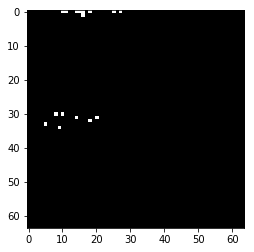

In [11]:
# get game state

def board_state():
    OFF_X, OFF_Y = -16, 34
    SCALE = 1/5

    ret_val, img = cam.read()

    img = np.transpose(img, axes=[1,0,2])
    img = np.flipud(img)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (int(img.shape[1]*SCALE), int(img.shape[0]*SCALE)))
    
    sr, sc = int(BOARD_Y*SCALE), int(BOARD_X*SCALE)
    #cv2.rectangle(img, (sc+OFF_X, sr+OFF_Y), (sc+OFF_X+BOARD_SIZE, sr+OFF_Y+BOARD_SIZE), 255, 4)
    
    img = img[sr+OFF_Y: sr+OFF_Y+BOARD_SIZE, sc+OFF_X: sc+OFF_X+BOARD_SIZE]
    #img[img>200] = 255
    
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 77, 11)
    img = img.astype(np.float64)
    img = 255-img
    img /= 255
    
    plt.imshow(img, cmap=plt.cm.gray)
    
    state = np.round(d.predict(img))
    
    return state

state = board_state()

vis(ones_state(state))

In [12]:
# create tictac ai
import t3_ai
t3 = t3_ai.AI(weights_path="t3_weights-19-0.24.hdf5")

model created with # params: 353
loading model weights from path: t3_weights-19-0.24.hdf5
loaded weights


In [13]:
ta.pen_up()
move_targeted(REST_X, REST_Y)

In [14]:
draw_board(BOARD_X, BOARD_Y)


X O O 
O X X 
X X O 


SerialException: write failed: [Errno 6] Device not configured

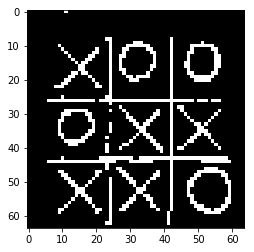

In [15]:
# Make move based on the state

def rc_from_int(a):
    r = int(np.floor(a/3.0))
    c = a%3
    return r,c

def make_move(state):
    state = ones_state(state)
    besta = t3.best_move(state)
    print(besta)
    if besta < 0:
        move_targeted(REST_X+10, REST_Y)
        return
    r, c = rc_from_int(besta)
    print(r,c)
    draw_x(r, c)

confidence = 0
prev_observed = None
    
while True:
    move_targeted(REST_X, REST_Y)
    
    state = board_state()
    clear_output(wait=True)
    vis(ones_state(state))
    
    if np.all(prev_observed == state):
        confidence += 1
    else:
        confidence = 0
        prev_observed = state.copy()
        
    if confidence < 20:
        continue
    else:
        confidence = 0
    
    num_xs = np.sum(state[0:9])
    num_os = np.sum(state[9:])
    
    clear_output(wait=True)
    if num_xs == 0 and num_os == 0:
        # first ai move condition
        make_move(state)
    elif num_xs == num_os:
        # human has made their move
        make_move(state)

In [ ]:
# take a camera shot

from scipy.misc import imsave

ret_val, img = cam.read()

img = np.transpose(img, axes=[1,0,2])
img = np.flipud(img)

print(img.shape)

imsave('ss.png', img)

In [88]:
# check cam images

while True:
    img, loc = capture_img(cam)
    clear_output(wait=True)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.show()

KeyboardInterrupt: 

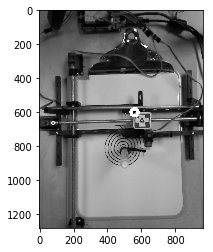

24949


In [15]:
def circle(x, y):
    r = 10
    ta.pen_up()
    for i, t in enumerate(np.linspace(0, np.pi * 2.0, 8)):
        move_targeted(x + np.cos(t) * r, y + np.sin(t) * r)
        if i == 0:
            ta.pen_down()
    ta.pen_up()
        
circle(REST_X, REST_Y+100)

In [ ]:
draw_x(0, 0)
draw_x(1, 0)
draw_x(2, 0)

draw_x(2, 1)
draw_x(1, 1)
draw_x(0, 1)

draw_x(0, 2)
draw_x(1, 2)
draw_x(2, 2)

move_targeted(REST_X, REST_Y)